# FAH GPU performance analysis example

**DISCLAIMER: the GPU benchmark data in this repo is experimental and not final. For now, the code and data presented here is intended as an example of parsing performance data from fah-core logs, and of the types of analysis that might be useful to automate intelligent assignment of work units to specific devices.**

Here we analyze performance data (`ns_per_day`) parsed from log files created by `fah-core` for the project `PROJ17101`. This project is intended to be a benchmark suite and contains 15 runs representative of the range of workloads run on FAH today.

In [1]:
import glob
import os
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from fah_log_parser import ParseError, parse, science_log
from fah_log_parser.util.pandas import parse_logs_to_df

## Parsing a single `science.log` file

In [2]:
log = parse(science_log, "../data/PROJ17101/RUN0/CLONE0/results0/science.log")

In [3]:
log.get_active_device()

Device(name='Hainan', vendor='Advanced Micro Devices, Inc.', version='OpenCL 1.2 AMD-APP (1800.7)')

In [4]:
log.fah_core_log.average_perf_ns_day

34.1653

## Parsing all logs in a project

In [5]:
files = glob.glob("../data/PROJ17101/RUN*/CLONE*/results*/science.log")
len(files)

42487

In [8]:
if os.path.exists("checkpoint"):
    data = pd.read_feather("checkpoint")
else:
    data = parse_logs_to_df("../data/PROJ17101/")
    data.to_feather("checkpoint")
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23946 entries, 0 to 23945
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   run              23946 non-null  int64  
 1   clone            23946 non-null  int64  
 2   gen              23946 non-null  int64  
 3   device_name      23946 non-null  object 
 4   perf_ns_per_day  23595 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 935.5+ KB


In [11]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby('device_name').filter(lambda x: len(x) > 10)
 .groupby('run').transform(lambda x: (x - x.mean()) / x.std()).rename('z_score_by_run')
 .groupby('device_name').mean()
).reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("z_score_by_run:Q", aggregate='mean'),
    y=alt.Y("device_name:N", sort='-x')
)

alt.Chart(...)

In [13]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby(['run', 'device_name']).filter(lambda x: len(x) > 10)
 .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
 .groupby(['run', 'device_name']).mean()
 .rename('mean_ns_per_day')
).reset_index()

alt.Chart(df).mark_point(filled=True).encode(
    x=alt.X('mean_ns_per_day:Q', scale=alt.Scale(type='log')),
    y=alt.Y('device_name:O', sort='-x'),
    color='run:N',
)

alt.Chart(...)

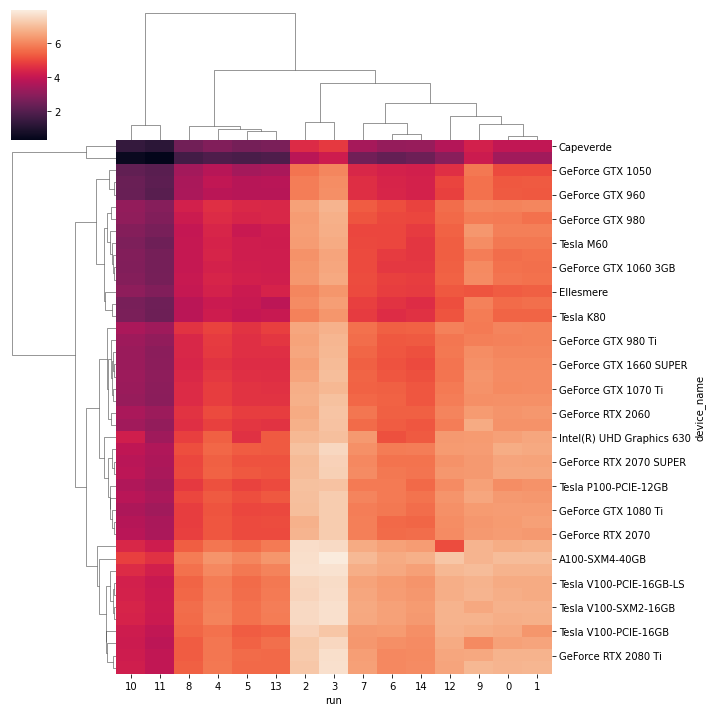

In [14]:
sns.clustermap(
    data
    .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
    .groupby(['run', 'device_name'])
    ['perf_ns_per_day']
    .mean()
    .pipe(lambda x: np.log(x))
    .unstack('run'))